## Crosshole traveltime tomography
We are doing a crosshole traveltime (e.g. seismics or GPR) tomography.
Assume two boreholes at x=0 and x=10m, with sources in the one and receivers
in the other, each with a spacing of 1m.
We discretize the subsurface by a 1x1m regular grid so that we can show
any model matrix just by `matshow`.

In [6]:
# define the grid by the node positions
x = 0:10;
y = 0:11;

We read a readily prepared raypath matrix (pyGIMLi notebook) which is a sparse matrix with the function `readdlm` into the integer positions i and j and the values v and create a sparse matrix.

In [8]:
using LinearAlgebra
using DelimitedFiles
using SparseArrays
IJV = readdlm("jacobian.ijv")
J = sparse(IJV[:, 1].+1, IJV[:, 2].+1, IJV[:, 3]);
G = Matrix(J);

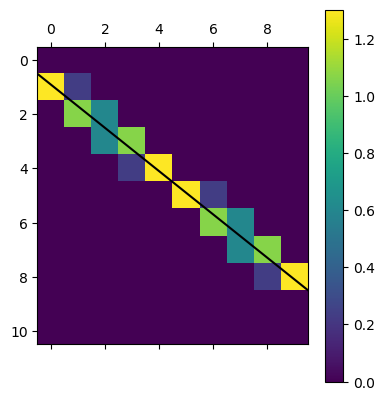

In [11]:
using PyPlot
nx = length(x) - 1
ny = length(y) - 1
function showModel(model, fixclim=true)
    matshow(transpose(reshape(model, nx, ny)))
    if fixclim
        clim(5, 25)
        set_cmap("Spectral_r")
    end
    colorbar();
    return
end
# Test it by showing a single ray
showModel(G[9, :], false)
plot([-0.5, 9.5], [0.5, 8.5], "k");

### Checkerboard
For tests, we often use a checkerboard model

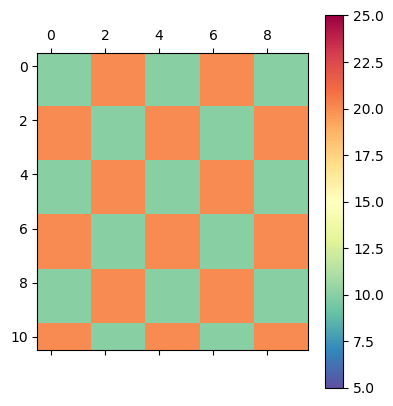

In [85]:
modelSyn = ones(nx, ny) *10 # homogeneous
for i = 1:nx
    for j = 1:ny
        # if isodd(i+j)
        if isodd(Int(floor(i/2+0.5))+Int(floor(j/2+0.5)))
            modelSyn[i, j] = 20
        end
    end
end
showModel(modelSyn[:])

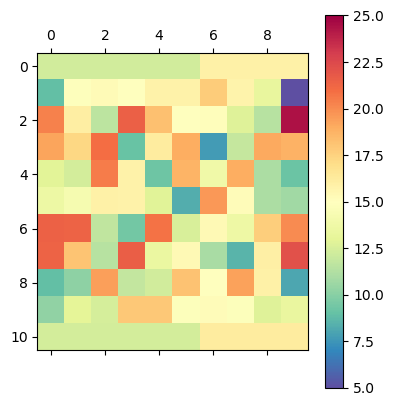

140.0 202.32329000000001

In [86]:
# Next we create synthetic data with some random noise
d = G * modelSyn[:]
print(minimum(d), " ", maximum(d))
errorLevel = d * 0.01 .+ 5.0
d += randn(size(d)) .* errorLevel;
showModel(pinv(G, rtol=0.1) * d)

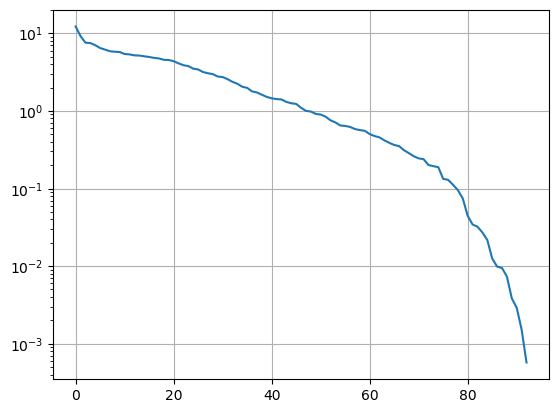

Rank: 93 s[1]: 12.256104420332292 s[r]: 0.0005724840682208662

In [87]:
s = svd(G)
r = rank(G)
print("Rank: ", r, " s[1]: ", s.S[1], " s[r]: ", s.S[r])
semilogy(s.S[1:r])
grid()

The singular value spectrum shows that it is ill-posed
(i.e. small singular values - steep sv spectrum)

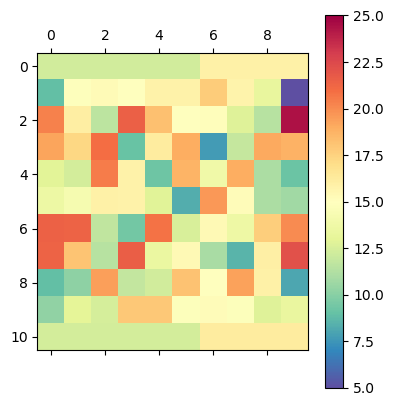

In [88]:
# We truncate small SV by rtol
model = pinv(G, rtol=0.1) * d
showModel(model)

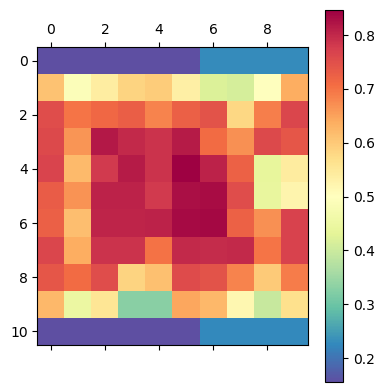

In [90]:
# Let us have a look at the resolution matrix
RM = pinv(G, rtol=0.03) * G
showModel(diag(RM), false)

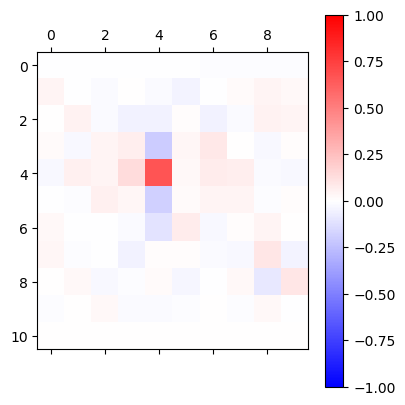

In [57]:
# Lets have a look at one column
showModel(RM[:, 10*4+5], false)  # 5th rows, 5th block
clim(-1, 1)
set_cmap("bwr")

### Tasks Part A 
For or all possible pseudoranks (1-93):

1. Compute the model using the truncated SVD inverse
1. Store the model norm in a vector
1. Store the residual norm in a vector
1. Compute the root-mean-square to the synthetic model

and plot those quantities over p.

Also plot the model norm against the residual norm and choose a `p` from these plots.

Which `p` has to be chosen according to the discrepancy principle?
(Compute the error-weighted misfit)

How does the resolution change with the optimum p?

Repeat the computations for two higher noise levels.

## Solution

The SVD inverse reads:
$${\bf m} = {\bf G}^\dagger {\bf d} = {\bf V}{\bf S}^{-1}{\bf U}^T {\bf d} = \sum_i \frac{U_i^T {\bf d}}{s_i} V_i $$
and can be truncated by
$${\bf m} = {\bf G}^\dagger {\bf d} = {\bf V_p}{\bf S_p}^{-1}{\bf U_p}^T {\bf d} = \sum_i^p \frac{U_i^T {\bf d}}{s_i} V_i = \sum_i \frac{f_i}{s_i}  U_i^T {\bf d} V_i $$


In [91]:
# The synthetic model (for easier playing with noise)
GD = (1.0 ./ errorLevel) .* G
sD = svd(GD)
print("max(s) unscaled: ", maximum(s.S), ", scaled: ", maximum(sD.S))
# We choose the method of filter factors setting them to one or zero instead of cutting U/V
UTd = transpose(sD.U) * (d ./ errorLevel);  # U^T * d

max(s) unscaled: 12.256104420332292, scaled: 1.8496666316544557

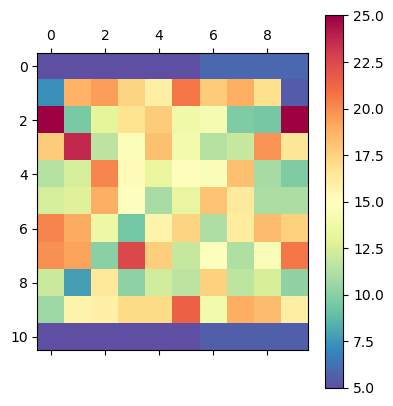

In [97]:
p = 40
f = zeros(size(sD.S))
f[1:p] .= 1.0
model = sD.V * (f ./ sD.S .* UTd)
showModel(model)

We use the chi-square measure:
$$\chi^2 = \frac{1}{N}\sum_i^N \left(\frac{d^{obs}_i-d^{syn}_i}{\epsilon_i}\right)^2=\frac{1}{N}\sum_i^N \hat{r}_i^2$$
$$\chi^2 = \frac{1}{N} \|{\bf\hat{r}}\|_2^2$$
A chi-square of 1 (a residual norm of $\sqrt{N}$) means the data are fitted within noise.

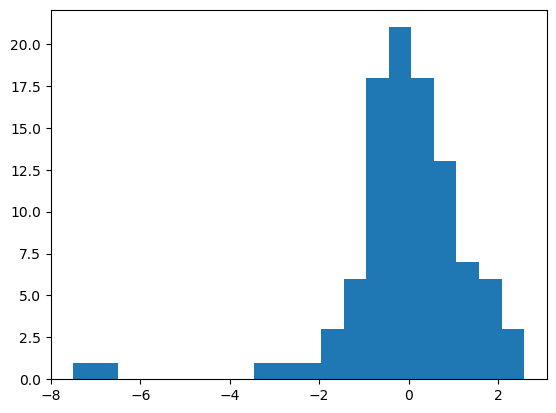

mean=-0.06942295261663453 std=1.4374015109034814 norm=14.318803786846676

In [98]:
using Statistics
f = zeros(length(s.S))
p = 36
f[1:p] .= 1.0  # increasingly set f to one
model = sD.V * (f ./ sD.S .* UTd)
residual = (G * model .- d) ./ errorLevel
print("mean=", mean(residual), " std=", std(residual), " norm=", norm(residual))
hist(residual, bins=20);

In [99]:
pMax = rank(G)
f = zeros(length(s.S))
modelNorm = zeros(pMax)
residualNorm = zeros(pMax)
chiSquare = zeros(pMax)
for p in 1:93
    f[p] = 1.0  # increasingly set f to one
    model = sD.V * (f ./ sD.S .* UTd)
    modelNorm[p] = norm(model)
    residual = (G * model - d) ./ errorLevel
    residualNorm[p] = norm(residual)
    chiSquare[p] = sum(residual.^2) / length(d)
end

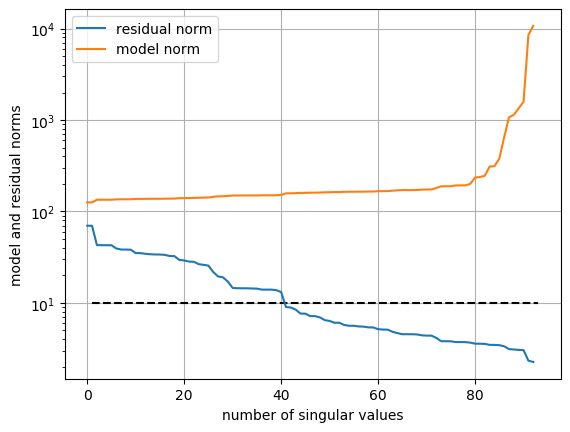

In [100]:
semilogy(residualNorm, label="residual norm")
semilogy(modelNorm, label="model norm")
hlines(sqrt(length(d)), 1, pMax, linestyles="dashed")
grid()
xlabel("number of singular values")
ylabel("model and residual norms")
legend();

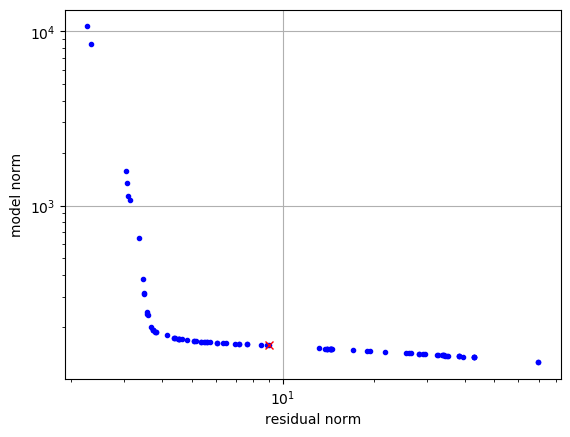

Optimum p after discrepancy principle: 42

In [101]:
pp = argmin(abs.(chiSquare .- 1))
print("Optimum p after discrepancy principle: ", pp)
loglog(residualNorm, modelNorm, "b.")
loglog(residualNorm[pp], modelNorm[pp], "rx")
grid()
xlabel("residual norm")
ylabel("model norm");

### Damped least squares
We now use the damped least squares solution

$$ {\bf m} = ({\bf G}^T {\bf G} + \lambda^2 {\bf I})^{-1} {\bf d} $$

It can also be expressed by SVD through a filtered sum
$$ {\bf m} = \sum_i \frac{s_i^2}{s_i^2+\lambda^2} \frac{U_i^T{\bf d}}{s_i} V_i = f_i \frac{U_i^T{\bf d}}{s_i} V_i $$
with the filter factors
$$ f_i = \frac{s_i^2}{s_i^2+\lambda^2} = \frac{1}{1+(\lambda_i/s_i)^2} $$

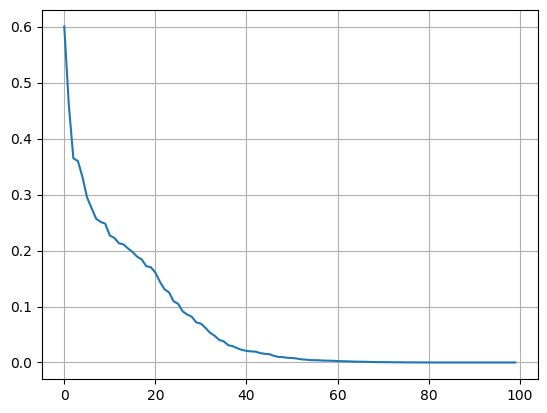

In [102]:
# Let's first have a look at the filter factors
lambda = 10  # then 1 and 0.1
lamByS = lambda ./ s.S
f = 1 ./ (lamByS.^2 .+ 1)
plot(f);
grid()
# It looks like a smooth truncation of singular values

We now look at the weighting functions
$$ \frac{s_i}{s_i^2+\lambda^2} = \frac{f_i}{s_i} $$
in comparison to the SVD weighting functions $1/s_i$

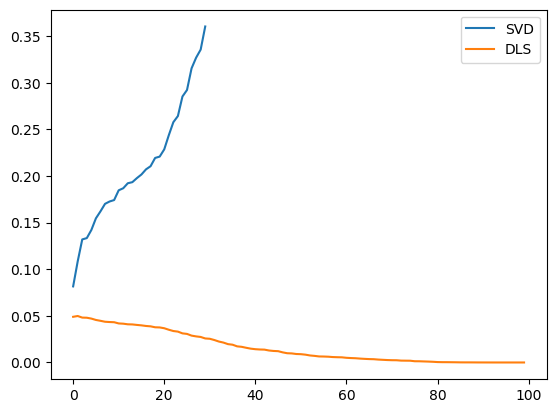

In [103]:
plot(1.0 ./ s.S[1:30], label="SVD")
plot(f ./ s.S, label="DLS")
legend();

### Task Part B - damped least squares
1. Create a logarithmically equidistant lambda vector
2. Do an interactive plotting (like above for pinv)
3. Plot the same quantities as above (model norm, residual norm) over $\lambda$ and against each other.
4. Which $\lambda$ do you choose according to the discrepancy principle?
5. Repeat with the same noise levels as above (try use same data).
6. Compute the resolution matrix and compare to TSVD

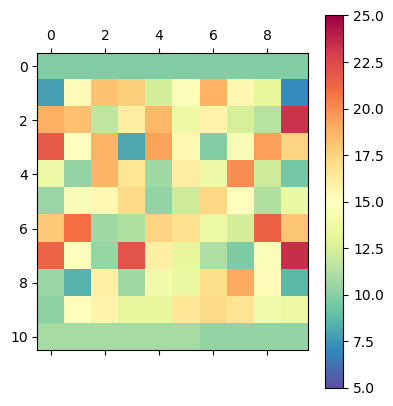

In [104]:
# Let's compute some solutions with different lambda
lambda = 1  # 10, 1, 0.1, 0.01
nM = size(G, 2)
IM = Matrix(I, nM, nM)  # identity matrix of size M
GT = transpose(G)
model = inv(GT * G + IM * lambda^2) * (GT * d)
showModel(model)

## Task Part C - Smoothness constraints
Define a roughness operator (see talk), e.g.: 
- How many model boundaries are in the model? Define a zero matrix!
- Run through all cells with a right neighbor and insert a -1 and a +1
- Run through all cells with a lower neighbor and insert a -1 and a +1
Replace the identity matrix by this matrix and repeat the previous steps (damped least squares) by using smoothness constraints.

In [110]:
# Let us first check in which order the cells are numbered
# showModel(1:length(model), false)

In [106]:
# all y directed boundaries
Cy = zeros(nx*(ny-1), nx*ny)
for i = 1:nx*(ny-1)
    Cy[i, i] = -1
    Cy[i, i+nx] = +1
end
# matshow(Cy)
# set_cmap("bwr")

In [107]:
# now all x directed boundaries
Cx = zeros((nx-1)*ny, nx*ny)
ind = 0
for iy = 1:ny
    for ix = 1:nx-1
        ind += 1  # count upwards
        i = (iy-1)*nx + ix
        Cx[ind, i] = -1
        Cx[ind, i+1] = +1
    end
end
# matshow(Cx)
# set_cmap("bwr")

In [108]:
C = vcat(Cx, Cy);
# matshow(C)
# set_cmap("bwr")

1.2573738079079804

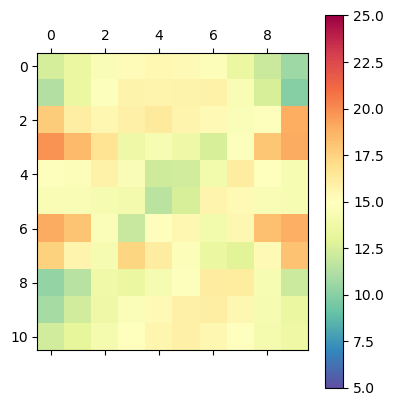

In [109]:
# Let's compute some solutions with different lambda
lambda = 0.3  # 10, 1, 0.1
GD = (1.0 ./ errorLevel) .* G
GDT = transpose(GD)
model = inv(GDT * GD + transpose(C) * C .* lambda^2) * (GDT * (d ./ errorLevel))
residual = (G * model - d) ./ errorLevel
display(sum(residual.^2) / length(d))  # 
showModel(model)

In [77]:
lambdaVector = 10 .^ range(-2, 2, step=0.1)  # log-equdist from 0.01 to +2
modelNorm = zeros(size(lambdaVector))
residualNorm = zeros(size(lambdaVector))
chiSquare = zeros(size(lambdaVector))
for i =  1:length(lambdaVector)
    lambda = lambdaVector[i]
    model = inv(GDT * GD + transpose(C) * C .* lambda^2) * (GDT * (d ./ errorLevel))
    modelNorm[i] = norm(model)
    residual = (G * model - d) ./ errorLevel
    residualNorm[i] = norm(residual)
    chiSquare[i] = sum(residual.^2) / length(d)    
end

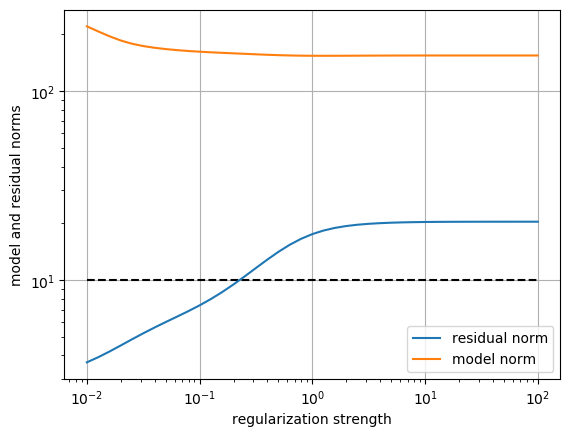

In [78]:
loglog(lambdaVector, residualNorm, label="residual norm")
loglog(lambdaVector, modelNorm, label="model norm")
hlines(sqrt(length(d)), lambdaVector[1], lambdaVector[end], linestyles="dashed")
grid()
xlabel("regularization strength")
ylabel("model and residual norms")
legend();

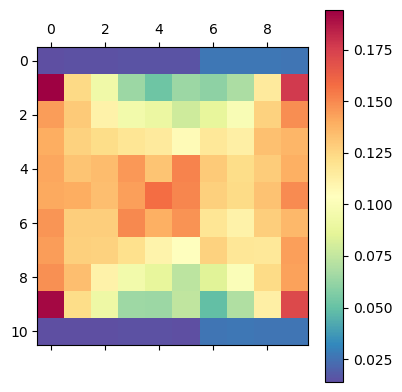

In [74]:
# Resolution matrix
lambda = 0.77  # 10, 1, 0.1
GTG = transpose(GD) * GD
CTC = transpose(C) * C
RM = inv(GTG + CTC .* lambda^2) * (GTG)
showModel(diag(RM), false)
set_cmap("Spectral_r")

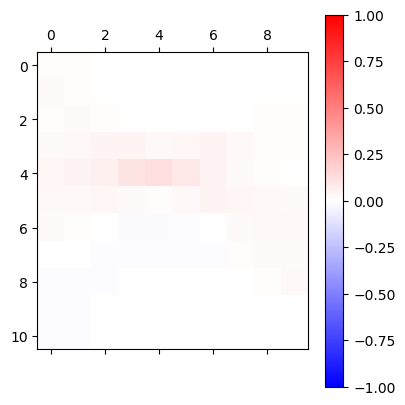

In [75]:
showModel(RM[:, 4*10+5], false)
clim(-1, 1)
set_cmap("bwr")

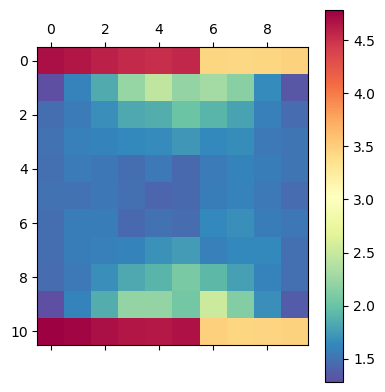

In [76]:
resrad = sqrt.(1 ./ diag(RM)./pi)
showModel(resrad, false)
set_cmap("Spectral_r")